In [10]:
import os
import cv2
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

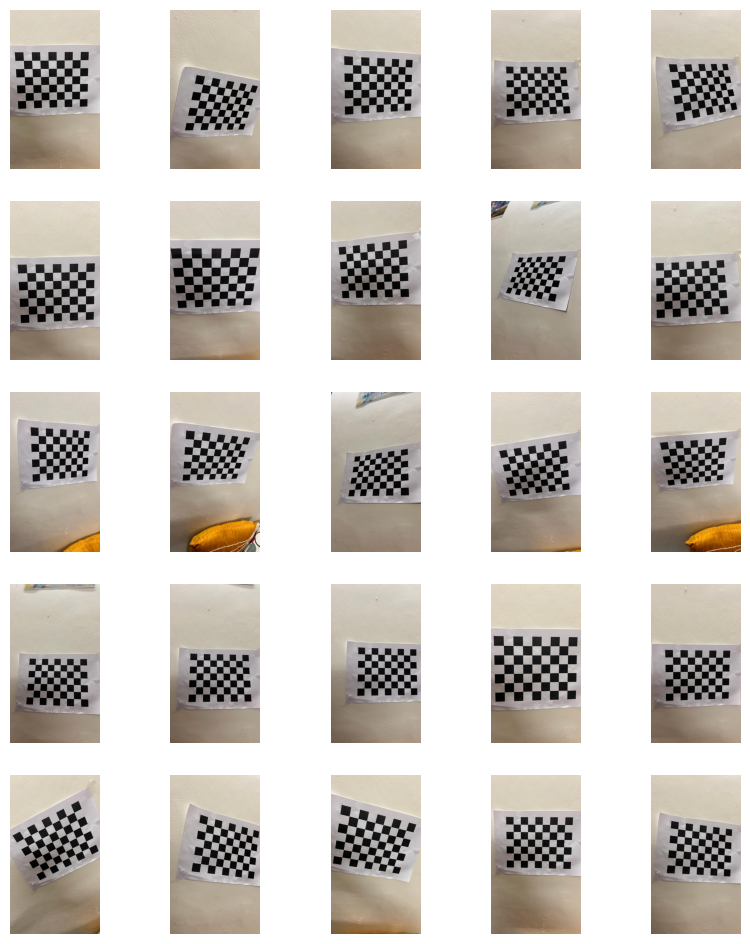

In [11]:
dataset_path = './dataset_1'
img_paths = [os.path.join(dataset_path, image) for image in os.listdir(dataset_path)]

plt.figure(figsize=(10, 12))
for i, image in enumerate(img_paths):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [12]:
CHESSBOARD = (6, 8)
FRAME_SIZE = (4032, 3024)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
flag = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE

objpoints, imgpoints, processed = [], [], {}

objp = np.zeros((CHESSBOARD[0] * CHESSBOARD[1], 3), np.float32)
objp[:, :2] = np.indices((CHESSBOARD[0], CHESSBOARD[1])).T.reshape(-1, 2)

for img in img_paths:
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD, flag)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        processed[img] = cv2.drawChessboardCorners(image, CHESSBOARD, corners2, ret)
    else:
        print("Corners not found in:", img)

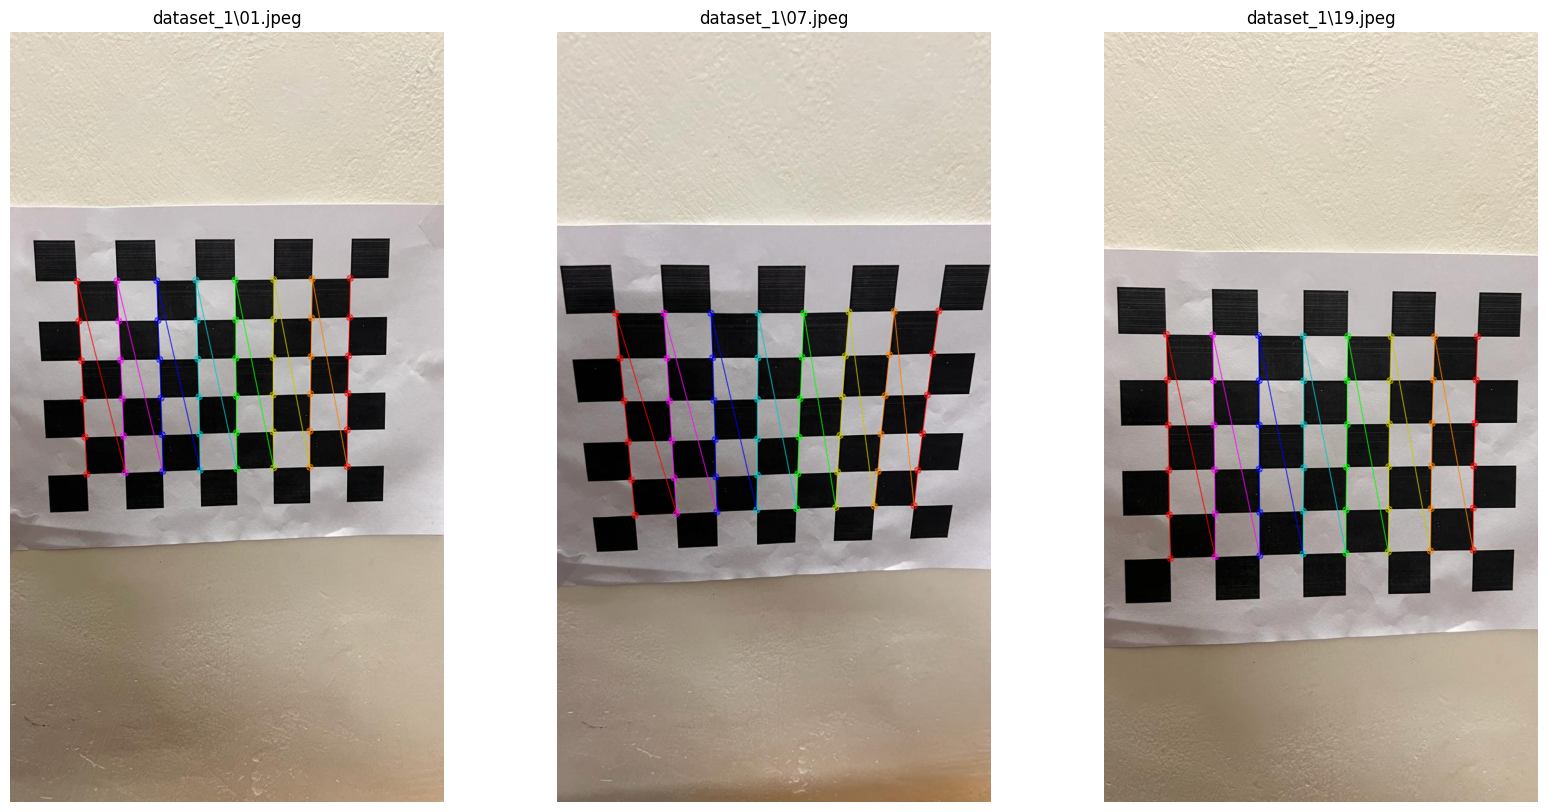

In [13]:
plt.figure(figsize=(20, 10))
for i, index in enumerate([0, 6, 18]):
    plt.subplot(1, 3, i+1)
    plt.title(img_paths[index].split("/")[-1])
    plt.imshow(cv2.cvtColor(processed[img_paths[index]], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

In [14]:
ret, camera_matrix, distortion, rotations, translations = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if not ret:
    print("Calibration failed. Use more images.")

In [15]:
print(camera_matrix)

[[956.63717904   0.         369.05488006]
 [  0.         957.55139543 651.41419152]
 [  0.           0.           1.        ]]


In [16]:
for img, rvec, tvec in zip(img_paths, rotations, translations):
    print("Image:", img)
    print(cv2.Rodrigues(rvec)[0])
    print(tvec)
    print()

Image: ./dataset_1\01.jpeg
[[ 0.01387206 -0.99699847 -0.07616832]
 [ 0.9885627   0.02511535 -0.14870444]
 [ 0.1501711  -0.07323433  0.9859439 ]]
[[ 3.04069414]
 [-3.79297031]
 [15.17175164]]

Image: ./dataset_1\02.jpeg
[[ 0.24194979  0.8905216  -0.3852682 ]
 [-0.94307737  0.12245551 -0.30920821]
 [-0.22817838  0.43815058  0.86945885]]
[[-2.70746524]
 [ 4.05746798]
 [15.05906233]]

Image: ./dataset_1\03.jpeg
[[-0.01154221 -0.96239679 -0.27140229]
 [ 0.99525091  0.01517927 -0.09615202]
 [ 0.09665608 -0.27122319  0.95765108]]
[[ 3.83208632]
 [-3.14506599]
 [16.372831  ]]

Image: ./dataset_1\04.jpeg
[[ 0.04927856 -0.98492456 -0.16581685]
 [ 0.98684224  0.02241676  0.16012458]
 [-0.15399355 -0.17152578  0.97306983]]
[[ 3.51132109]
 [-2.60243377]
 [18.44676272]]

Image: ./dataset_1\05.jpeg
[[ 0.16534949 -0.90263686 -0.39737418]
 [ 0.97702249  0.09497642  0.19080494]
 [-0.13448639 -0.41979301  0.89760082]]
[[ 3.90409873]
 [-3.02402901]
 [18.152254  ]]

Image: ./dataset_1\06.jpeg
[[ 0.0161202 

In [21]:
k1, k2, p1, p2, k3 = distortion.ravel()
print("Distortion Coefficients:")
print("Radial Distortion Coefficients (k1, k2, k3):", k1, k2, k3)
print("Tangential Distortion Coefficients (p1, p2):", p1, p2)

Distortion Coefficients:
Radial Distortion Coefficients (k1, k2, k3): 0.19763674774002904 -0.7068638884670998 0.04877253402973375
Tangential Distortion Coefficients (p1, p2): 0.003369370902802484 0.00698243563481215


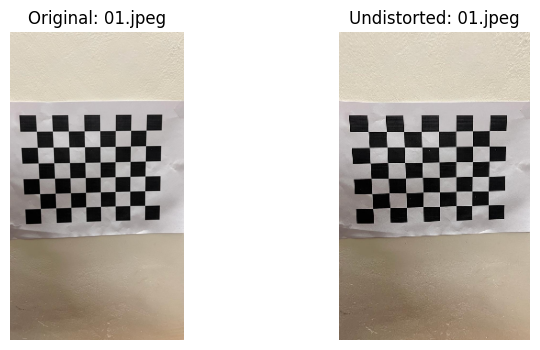

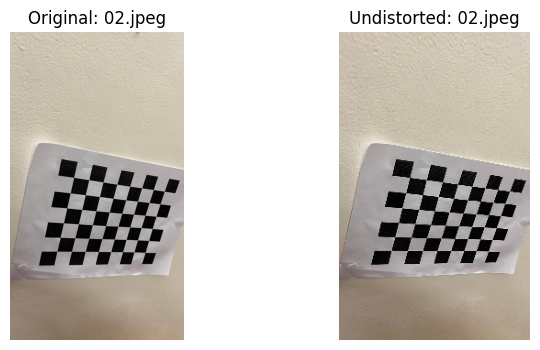

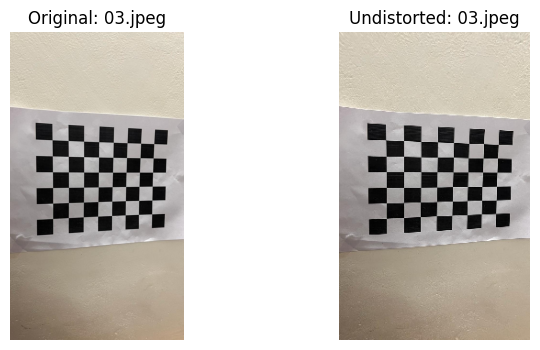

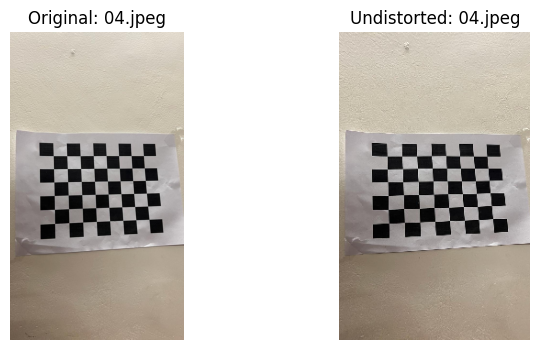

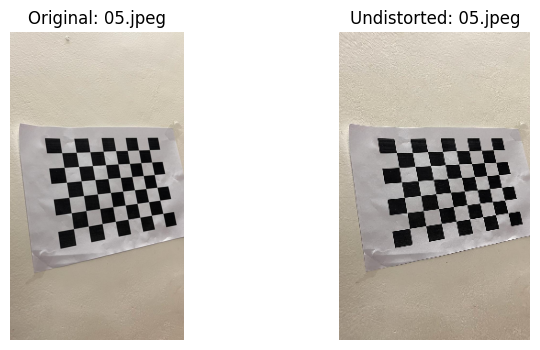

In [41]:
for i, index in enumerate([0, 1, 2, 3, 4]):
    # Read and convert to RGB
    distorted_img = cv2.cvtColor(cv2.imread(img_paths[index]), cv2.COLOR_BGR2RGB)
    height, width = distorted_img.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, distortion, (width, height), 0.8, (width, height))
    undistorted_img = cv2.undistort(distorted_img, camera_matrix, distortion, None, new_camera_matrix)
    x, y, w, h = roi
    undistorted_img = undistorted_img[y:y+h, x:x+w]

    # Create a new figure for each pair
    plt.figure(figsize=(8, 4))

    # Original image (Left)
    plt.subplot(1, 2, 1)
    plt.imshow(distorted_img)
    plt.title(f"Original: {img_paths[index].split('\\')[-1]}")
    plt.axis("off")

    # Undistorted image (Right)
    plt.subplot(1, 2, 2)
    plt.imshow(undistorted_img)
    plt.title(f"Undistorted: {img_paths[index].split('\\')[-1]}")
    plt.axis("off")

    # Show the figure
    plt.show()


In [48]:
errors = []
for objpoint, imgpoint, rvec, tvec in zip(objpoints, imgpoints, rotations, translations):
    projected_points, _ = cv2.projectPoints(objpoint, rvec, tvec, camera_matrix, distortion)
    error = cv2.norm(imgpoint, projected_points, cv2.NORM_L2) / len(projected_points)
    errors.append(error)

mean, std = np.mean(errors), np.std(errors)
print("Mean Reprojection Error:", mean)
print("Standard Deviation of Reprojection Error:", std)

Mean Reprojection Error: 0.06971433798479719
Standard Deviation of Reprojection Error: 0.023213701862424174


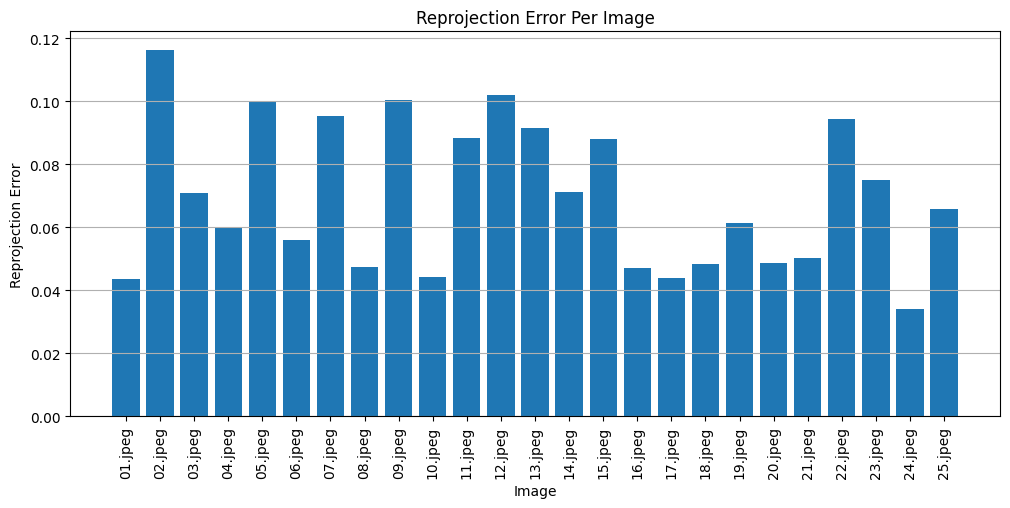

In [51]:
plt.figure(figsize=(12, 5))

plt.bar(range(len(errors)), errors)
plt.title("Reprojection Error Per Image")
plt.xlabel("Image")
plt.ylabel("Reprojection Error")
plt.xticks(range(len(errors)), [image.split("\\")[-1] for image in img_paths], rotation='vertical')

plt.grid(True, axis = 'y')
plt.show()

In [68]:
def get_corners(is_reprojected):
    plt.figure(figsize=(13, 16))

    for i, image_path in enumerate(img_paths):
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        corners = imgpoints[i].reshape(-1, 2)
        projections, _ = cv2.projectPoints(objpoints[i], rotations[i], translations[i], camera_matrix, distortion)
        projections = projections.reshape(-1, 2)

        plt.subplot(5, 5, i+1)
        plt.imshow(image)

        if(is_reprojected):
            plt.scatter(projections[:, 0], projections[:, 1], s=5, color="blue")
        else:
            plt.scatter(corners[:, 0], corners[:, 1], s=5, color="red")
        plt.axis("off")

    plt.show()


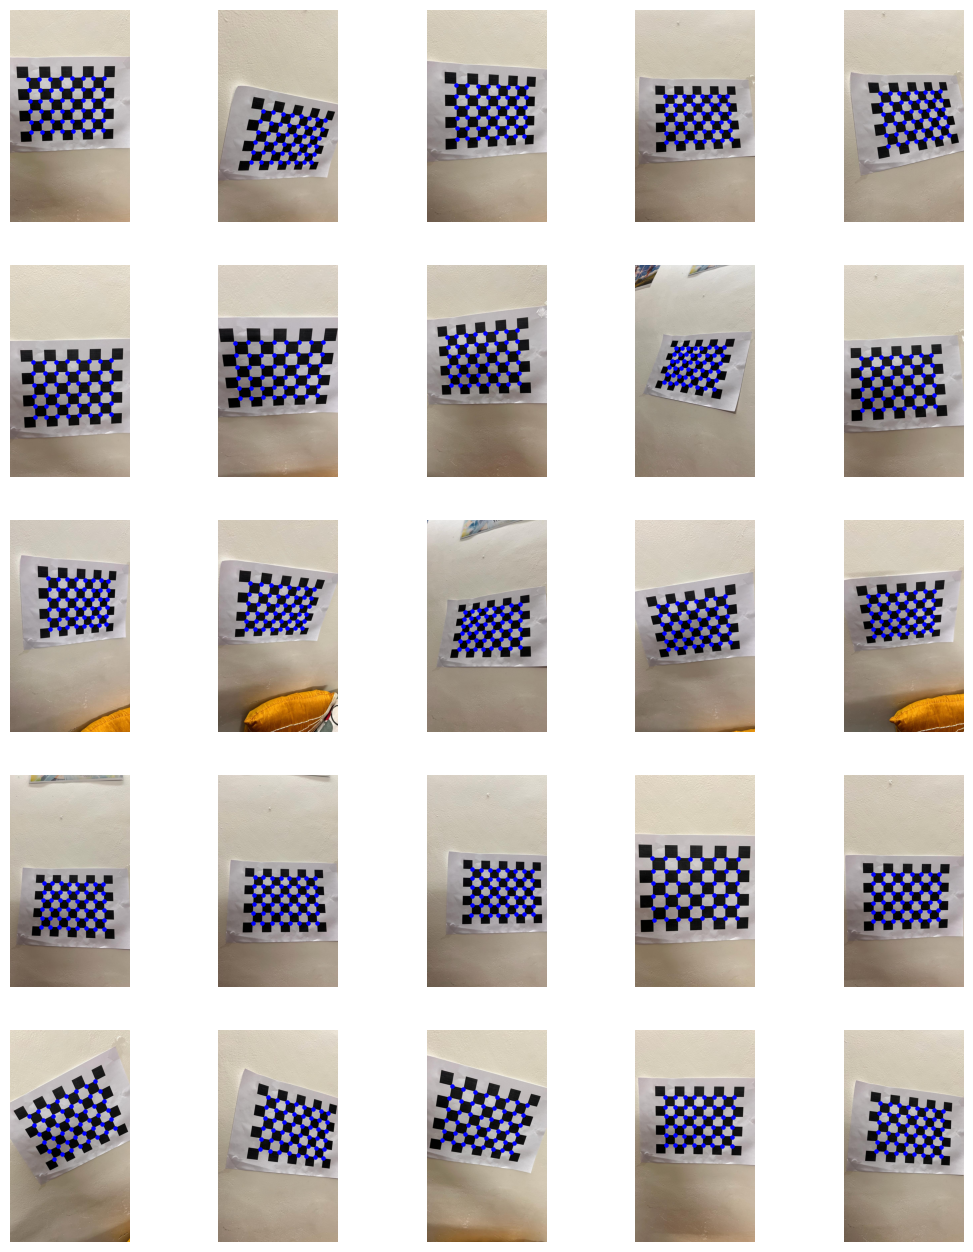

In [69]:
get_corners(True)

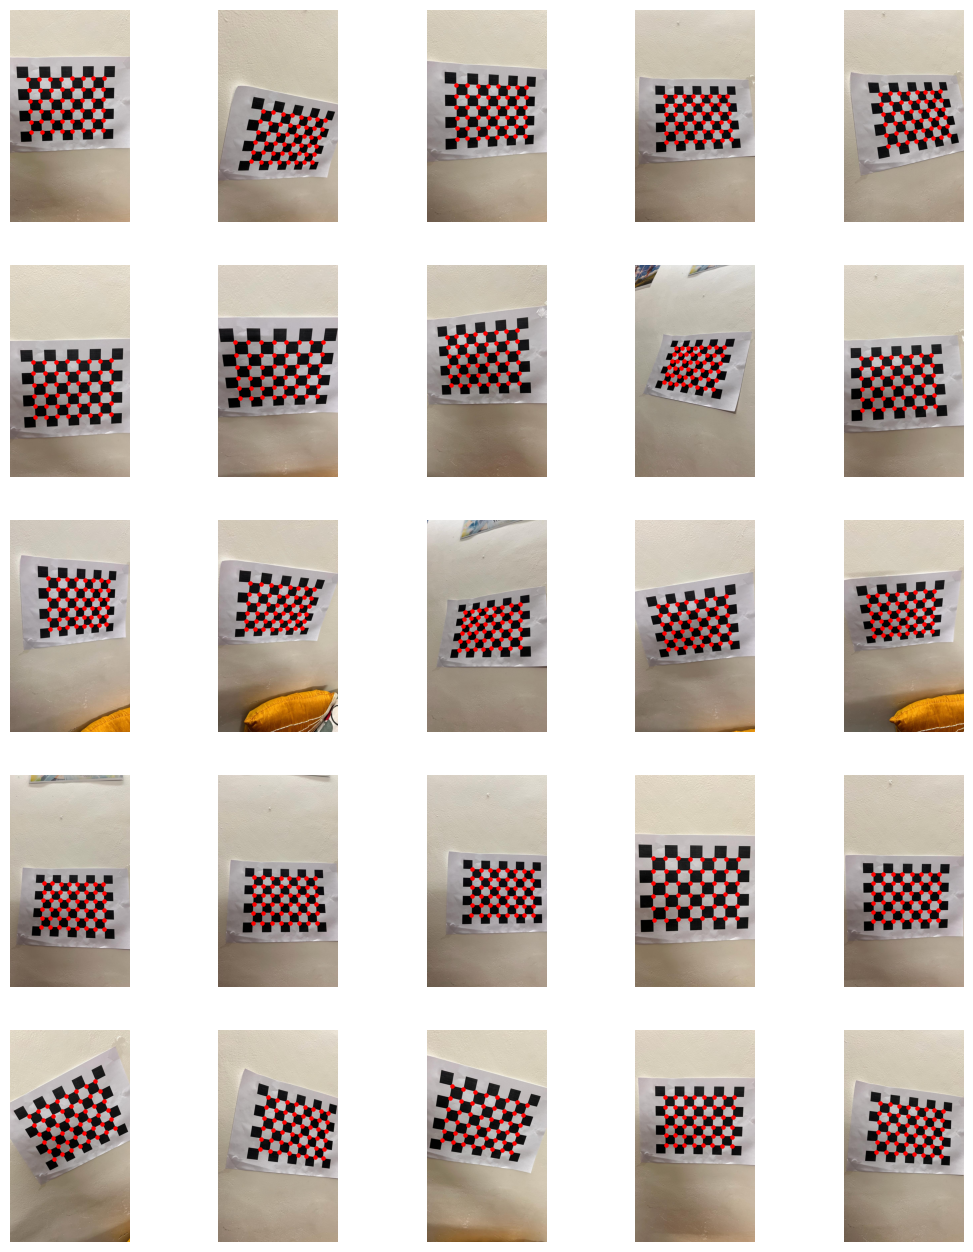

In [70]:
get_corners(False)

In [79]:
print("Normal Plane for Images:")
for image_path, rvec in zip(img_paths, rotations):
    R, _ = cv2.Rodrigues(rvec)
    normal = R[:, 2]
    normal /= np.linalg.norm(normal)
    print(f"{image_path.split('\\')[-1]}:", np.round(normal, 5))

Normal Plane for Images:
01.jpeg: [-0.07617 -0.1487   0.98594]
02.jpeg: [-0.38527 -0.30921  0.86946]
03.jpeg: [-0.2714  -0.09615  0.95765]
04.jpeg: [-0.16582  0.16012  0.97307]
05.jpeg: [-0.39737  0.1908   0.8976 ]
06.jpeg: [-0.08327 -0.12753  0.98833]
07.jpeg: [-0.10315 -0.40167  0.90996]
08.jpeg: [ 0.18877 -0.06636  0.97978]
09.jpeg: [0.45456 0.40009 0.7958 ]
10.jpeg: [-0.02287  0.12383  0.99204]
11.jpeg: [-0.39827 -0.18715  0.89797]
12.jpeg: [-0.34643 -0.5281   0.7753 ]
13.jpeg: [0.35821 0.39861 0.84427]
14.jpeg: [ 0.04522 -0.32517  0.94457]
15.jpeg: [-0.12779 -0.50726  0.85226]
16.jpeg: [0.07201 0.21723 0.97346]
17.jpeg: [-0.09543  0.19721  0.97571]
18.jpeg: [-0.14608  0.07387  0.98651]
19.jpeg: [-0.10773 -0.08643  0.99042]
20.jpeg: [-0.13551 -0.10599  0.98509]
21.jpeg: [-0.09764 -0.27446  0.95663]
22.jpeg: [-0.36035  0.01814  0.93264]
23.jpeg: [-0.16459 -0.3628   0.91721]
24.jpeg: [ 0.03567 -0.11055  0.99323]
25.jpeg: [-0.22325  0.0683   0.97236]


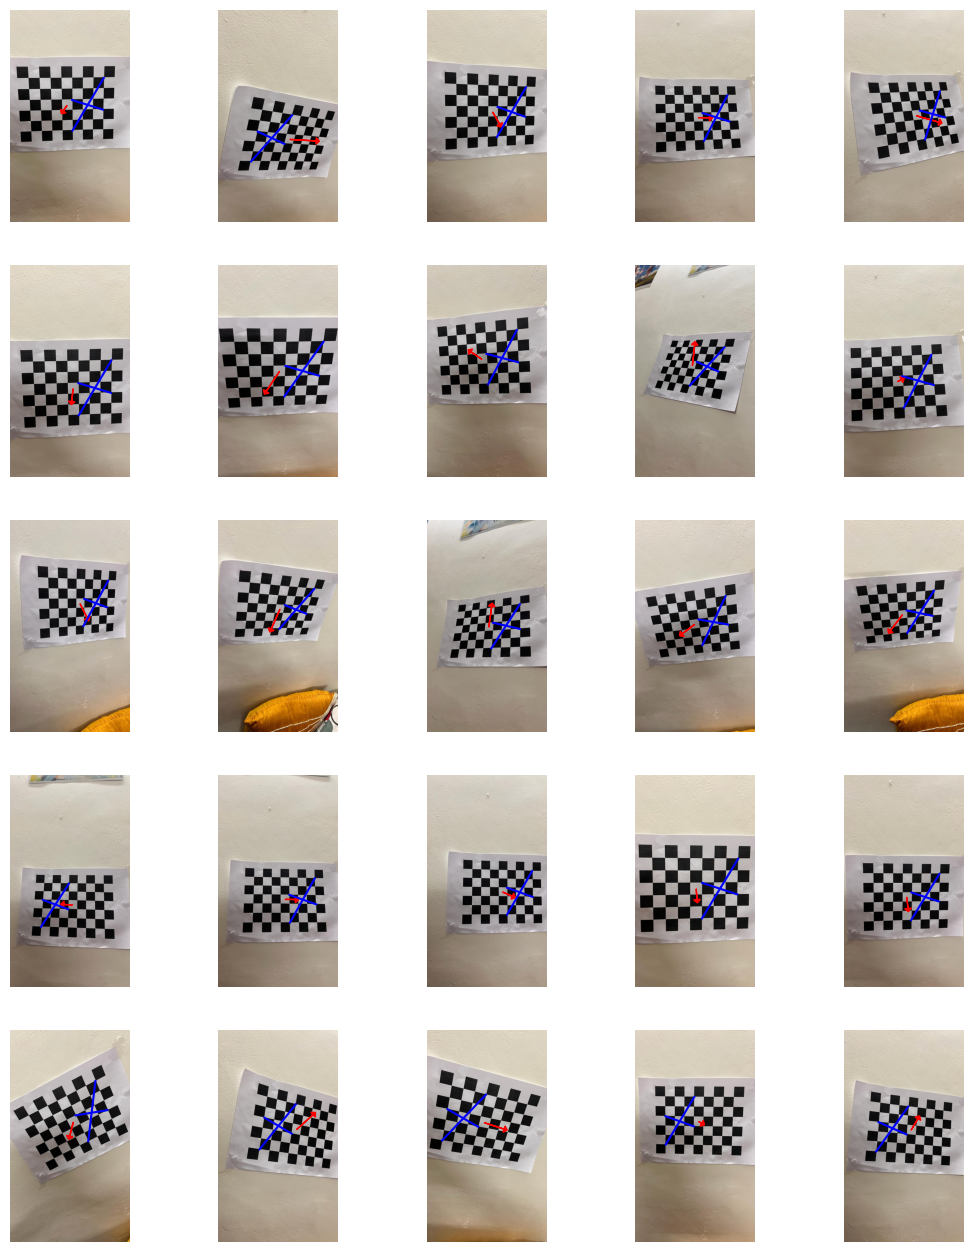

In [81]:
plt.figure(figsize=(13, 16))

for i, image_path in enumerate(img_paths):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    corners = imgpoints[i].reshape(-1, 2)
    on_plane_1 = np.array([corners[0], corners[23]])
    on_plane_2 = np.array([corners[3], corners[20]])

    centroid = np.mean(objpoints[i], axis=0)
    normal = cv2.Rodrigues(rotations[i])[0][:, 2]
    end = centroid - 3*normal
    projected, _ = cv2.projectPoints(np.array([centroid, end]), rotations[i], translations[i], camera_matrix, distortion)
    projected = projected.reshape(-1, 2)

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.plot(on_plane_1[:, 0], on_plane_1[:, 1], color="blue", linewidth=1.5)
    plt.plot(on_plane_2[:, 0], on_plane_2[:, 1], color="blue", linewidth=1.5)
    plt.arrow(projected[0, 0], projected[0, 1], projected[1, 0]-projected[0, 0], projected[1, 1]-projected[0, 1], color="red", head_length=20, head_width=40)
    plt.axis("off")

plt.show()